Авторы материала: аспирант Мехмата МГУ Евгений Колмаков, программист-исследователь Mail.ru Group Юрий Кашницкий.

# <center>Домашнее задание № 3. Опциональная часть 
## <center> Реализация алгоритма построения дерева решений

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1k4jn-czjTL_6pnQD96N3kA0uSq3cCGHcfNdKpfICURA/edit?usp=sharing).**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from decision_tree import gini, entropy, variance, mad_median

In [2]:
x = np.array([0, 0, 1, 1, 2, 1, 0])
print(gini(x))
print(entropy(x))
print(variance(x))
print(mad_median(x))

0.6122448979591837
1.4488156357251847
0.4897959183673469
0.5714285714285714


Зафиксируем заранее `random_state` (a.k.a. random seed). Это должно повысить вероятность полной воспроизводимости результатов, впрочем, замечено, что тем не менее небольшие флуктуации возможны (например, качества прогнозов дерева, которое мы сейчас вырастим) в случае разных ОС.

In [3]:
RANDOM_STATE = 17

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [4]:
%load_ext autoreload
%autoreload 2

## Тестирование реализованного алгоритма

### Классификация

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [5]:
data = load_digits()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2, 
    random_state=RANDOM_STATE
)

In [60]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
grid = GridSearchCV(
    tree, 
    parameters, 
    cv = 5, 
    n_jobs = -1,
    verbose = True, 
    scoring = 'accuracy'
)
grid.fit(X_train, y_train);
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'criterion': 'entropy', 'max_depth': 8}
0.8656924147529576


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished


С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [61]:
from decision_tree import DecisionTree
parameters = {
    'max_depth': range(3, 11), 
    'criterion': ['gini', 'entropy']
}
tree = DecisionTree()
grid = GridSearchCV(
    tree, 
    parameters, 
    cv = 5, 
    n_jobs = -1,
    verbose = True, 
    scoring = 'accuracy'
)
grid.fit(X_train, y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.0min finished


In [62]:
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'entropy', 'max_depth': 10}
0.8531663187195546


Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

In [63]:
gini_mask = grid.cv_results_['param_criterion'] == 'gini'
gini_score = grid.cv_results_['mean_test_score'][gini_mask]

entropy_mask = grid.cv_results_['param_criterion'] == 'entropy'
entropy_score = grid.cv_results_['mean_test_score'][entropy_mask]

x = [i for i in parameters['max_depth']]

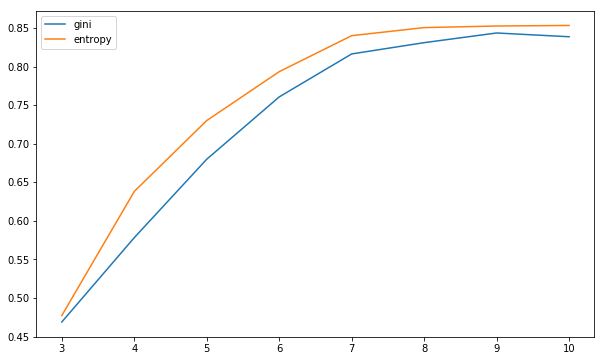

In [64]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, gini_score, label='gini')
ax.plot(x, entropy_score, label='entropy')
leg = ax.legend();

**Выберите верные утверждения:**
1. Оптимальное значение `max_depth` для каждого критерия достигается на отрезке [4, 9].
2. На отрезке [3, 10] построенные графики не пересекаются. <--
3. На отрезке [3, 10] построенные графики пересекаются ровно один раз. 
4. Наилучшее качество при `max_depth` на интервале [3, 10] достигается при использовании критерия `gini`.
5. Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения `max_depth` на интервале [3, 10]. <--

**Чему равны найденные оптимальные значения параметров max_depth и criterion?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy'; <--
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [67]:
tree_classifier = DecisionTree(max_depth = 10, criterion = 'entropy')
tree_classifier.fit(X_train, y_train)

DecisionTree(criterion='entropy', debug=False, k=10, max_depth=10,
       min_samples_split=2)

In [68]:
probas = tree_classifier.predict_proba(X_test)
max(probas.mean(axis=0))

0.11944444444444445

Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

**Вопрос:** Чему примерно равна максимальная вероятность в полученном векторе?
1. 0.127 
2. 0.118 <--
3. 1.0
4. 0.09

### Регрессия

С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [69]:
data = load_boston()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2, 
    random_state=RANDOM_STATE
)

С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [70]:
from decision_tree import DecisionTree
parameters = {
    'max_depth': range(2, 9), 
    'criterion': ['variance', 'mad_median']
}
tree = DecisionTree()
grid = GridSearchCV(
    tree, 
    parameters, 
    cv = 5, 
    n_jobs = -1,
    verbose = True, 
    scoring = 'neg_mean_squared_error'
)
grid.fit(X_train, y_train);

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  3.6min finished


In [71]:
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'variance', 'max_depth': 5}
-22.518856548697045


Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

In [72]:
variance_mask = grid.cv_results_['param_criterion'] == 'variance'
variance_score = grid.cv_results_['mean_test_score'][variance_mask]

mad_median_mask = grid.cv_results_['param_criterion'] == 'mad_median'
mad_median_score = grid.cv_results_['mean_test_score'][mad_median_mask]

x = [i for i in range(2, 9)]

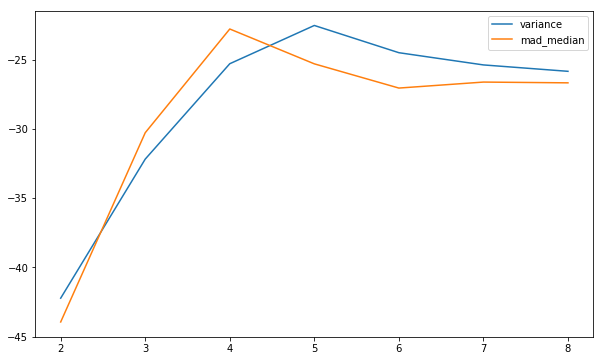

In [73]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, variance_score, label='variance')
ax.plot(x, mad_median_score, label='mad_median')
leg = ax.legend();

**Выберите верные утверждения:**
1. На отрезке [2, 8] построенные графики не пересекаются.
2. На отрезке [2, 8] построенные графики пересекаются ровно один раз.
3. Оптимальное значение `max_depth` для каждого из критериев достигается на границе отрезка [2, 8].
4. Наилучшее качество при `max_depth` из [2, 8] достигается при использовании критерия `mad_median`.

**Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median'; 
6. max_depth = 5, criterion = 'variance'; <--